In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import CRS
import sys
import os
import pickle
import matplotlib.pyplot as plt
from pyproj import CRS
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
from matplotlib_scalebar.scalebar import ScaleBar
from citymob import import_csv_w_wkt_to_gdf
import re
crs0=3035
cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria']

In [2]:
city='Toulouse'
country=countries[cities_all.index(city)]
print(city, country)
if (country in ['Spain','France']) & (city not in ['Paris','Paris_large']):
    fp='../outputs/density_geounits/' + city + '_pop_density_mixres.csv'
    plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')
elif city =='Paris':
    fp='../outputs/density_geounits/' + city + '_pop_density_lowres.csv'
    plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geo_unit')
    plz_gdf.rename(columns={'geo_unit':'geocode'},inplace=True)
elif city =='Paris_large':
    fp='../outputs/density_geounits/Paris_pop_density_lowres_large.csv'
    plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geo_unit')
    plz_gdf.rename(columns={'geo_unit':'geocode'},inplace=True)
else:
    fp='../outputs/density_geounits/' + city + '_pop_density.csv'
    plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')

df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')

fp='../outputs/ML_Results/shap/dist_agg/' + city + '.pkl'
with open(fp, 'rb') as f:
    shap_values=pickle.load(f) 

shap_values=shap_values*0.001

fp='../outputs/ML_Results/shap/dist_agg/' + city + '_df.pkl'
with open(fp, 'rb') as f:
    df_agg=pickle.load(f) 

if (country == 'Germany'): 
    fp='../outputs/city_boundaries/' + city + '_basic.csv'
else:
    fp='../outputs/city_boundaries/' + city + '.csv'
boundary=import_csv_w_wkt_to_gdf(fp,crs=crs0)

fp='../source/citycenters/centers.csv'
centers=import_csv_w_wkt_to_gdf(fp,crs=4326)
centers.to_crs(crs0, inplace=True)
cp=centers.loc[centers['City']==city,]

Toulouse France


In [3]:
shap_values

,DistSubcenter_res,DistCenter_res,UrbPopDensity_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,LU_UrbFab_res,LU_Comm_res,Commute_Trip,Age
0,-0.109446,-0.221802,-0.557393,-0.384868,-0.466545,-0.448112,-0.079307,-0.015387,-0.327141,-0.021238
1,-0.116818,-0.201456,-0.545999,-0.353445,-0.573115,-0.401034,-0.123858,-0.015434,-0.311951,-0.058180
2,-0.121683,-0.223002,-0.535382,-0.198557,-0.453168,-0.322257,0.014010,-0.018246,-0.341090,-0.043712
3,-0.073056,-0.253088,-0.595654,-0.418189,-0.519954,-0.394373,-0.156916,-0.000697,-0.349591,-0.053452
4,-0.183208,-0.160294,-0.735971,-0.244279,-0.514595,-0.279716,-0.185596,-0.012401,-0.338592,-0.014998
...,...,...,...,...,...,...,...,...,...,...
178,0.180372,0.319119,0.019549,0.173331,0.840823,0.186114,-0.190087,-0.029691,0.181719,0.035297
179,0.196443,-0.017006,0.473494,-0.126129,0.632780,0.225883,-0.210648,-0.025870,0.341519,-0.050014
180,0.496489,0.071468,0.277986,0.306390,0.960587,0.415442,0.220528,0.083450,0.316378,0.055962
181,0.378672,-0.037045,0.297896,0.228463,0.888353,0.315605,0.133917,0.065314,0.183716,0.006256


In [4]:
feat_ori=shap_values.loc[:,['DistCenter_res','DistSubcenter_res','UrbPopDensity_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','LU_UrbFab_res','LU_Comm_res']]
#drop(columns={'Commute_Trip','IncomeDetailed_Numeric','Age'},errors='ignore')
feat_ori

,DistCenter_res,DistSubcenter_res,UrbPopDensity_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,LU_UrbFab_res,LU_Comm_res
0,-0.221802,-0.109446,-0.557393,-0.384868,-0.466545,-0.448112,-0.079307,-0.015387
1,-0.201456,-0.116818,-0.545999,-0.353445,-0.573115,-0.401034,-0.123858,-0.015434
2,-0.223002,-0.121683,-0.535382,-0.198557,-0.453168,-0.322257,0.014010,-0.018246
3,-0.253088,-0.073056,-0.595654,-0.418189,-0.519954,-0.394373,-0.156916,-0.000697
4,-0.160294,-0.183208,-0.735971,-0.244279,-0.514595,-0.279716,-0.185596,-0.012401
...,...,...,...,...,...,...,...,...
178,0.319119,0.180372,0.019549,0.173331,0.840823,0.186114,-0.190087,-0.029691
179,-0.017006,0.196443,0.473494,-0.126129,0.632780,0.225883,-0.210648,-0.025870
180,0.071468,0.496489,0.277986,0.306390,0.960587,0.415442,0.220528,0.083450
181,-0.037045,0.378672,0.297896,0.228463,0.888353,0.315605,0.133917,0.065314


Berlin Germany
Dresden Germany
Düsseldorf Germany
Frankfurt am Main Germany
Kassel Germany


C:\Users\peter\AppData\Local\Temp\ipykernel_21708\1267180028.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')


Leipzig Germany
Magdeburg Germany
Potsdam Germany
Clermont France
Dijon France
Lille France
Lyon France
Montpellier France
Nantes France
Nimes France
Paris France
Toulouse France
Madrid Spain


C:\Users\peter\AppData\Local\Temp\ipykernel_21708\1267180028.py:21: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')


Wien Austria


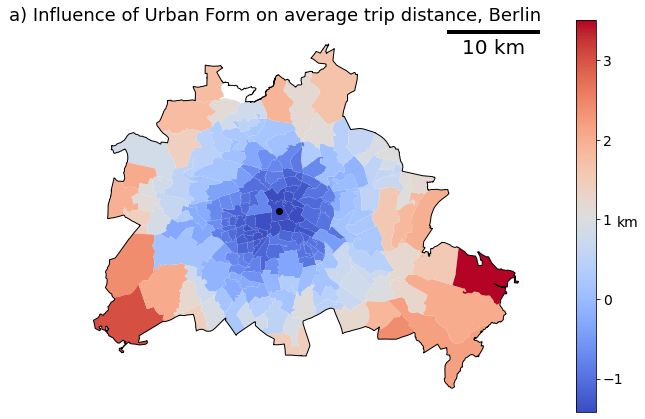

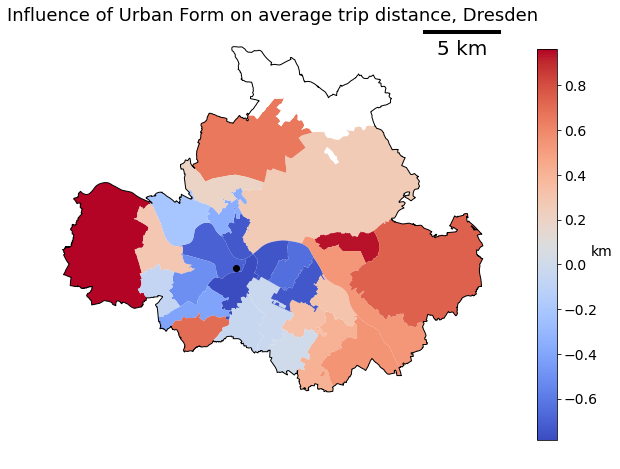

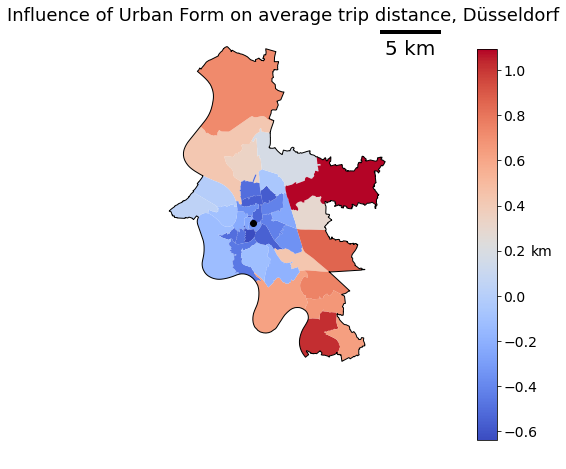

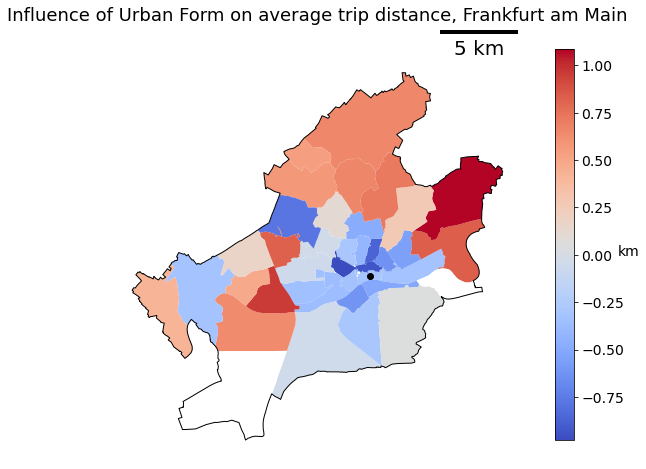

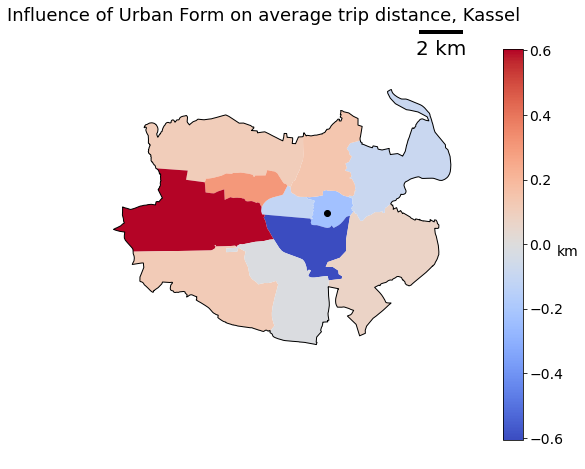

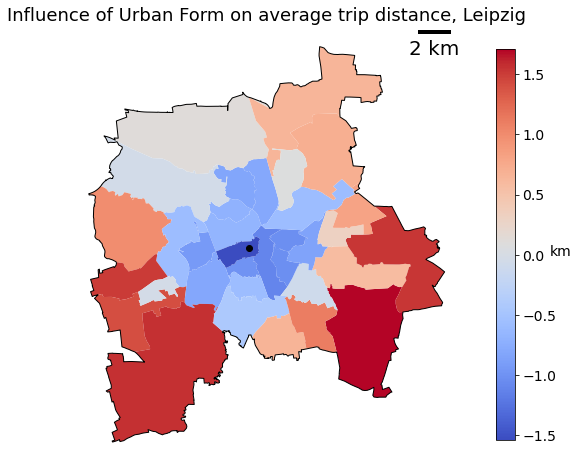

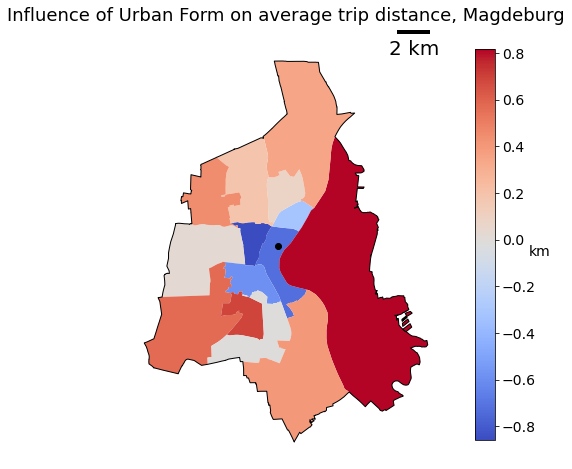

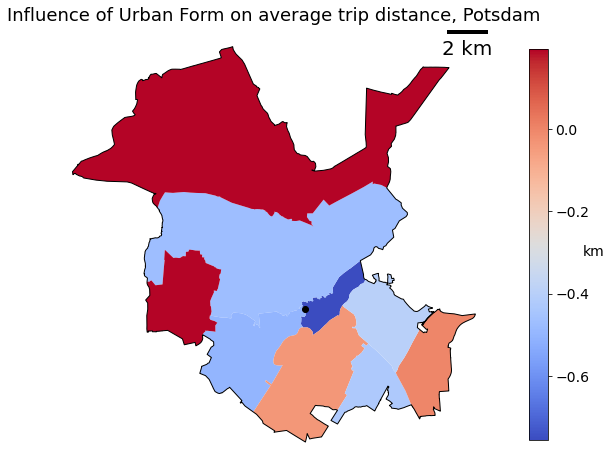

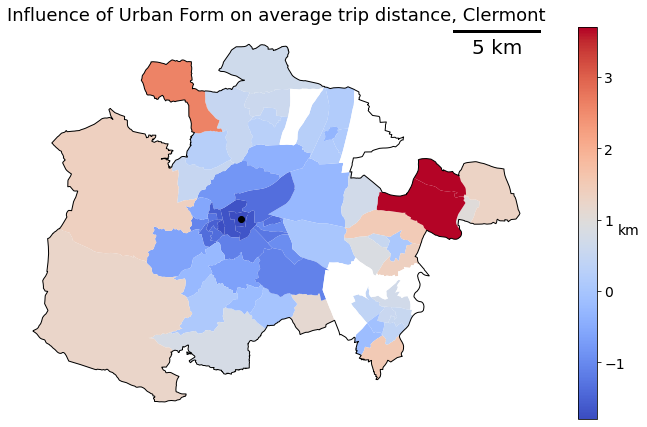

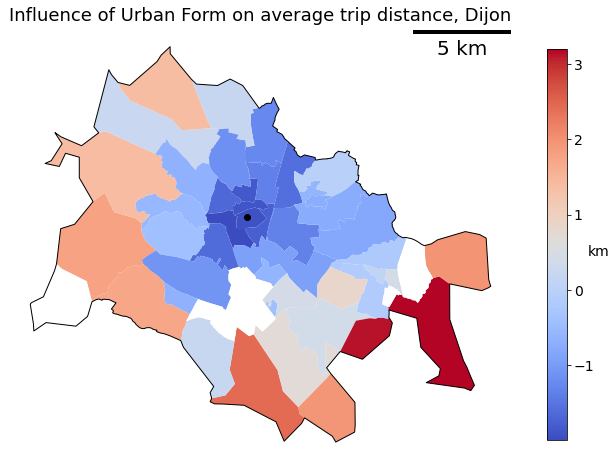

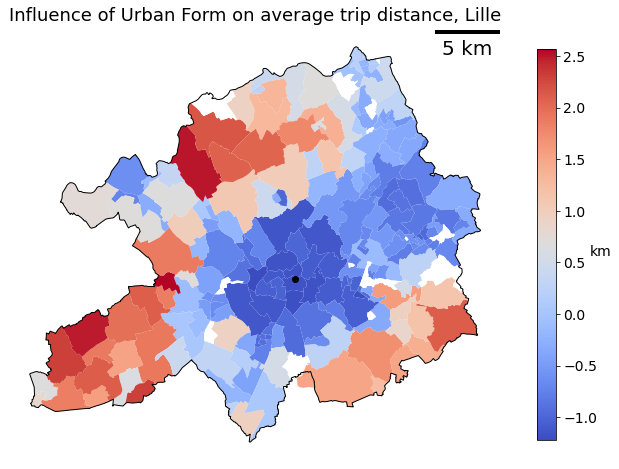

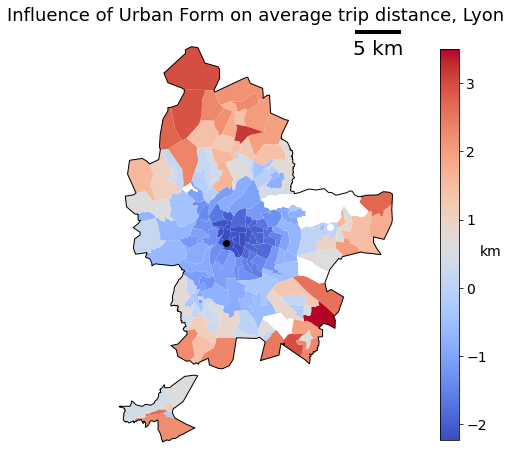

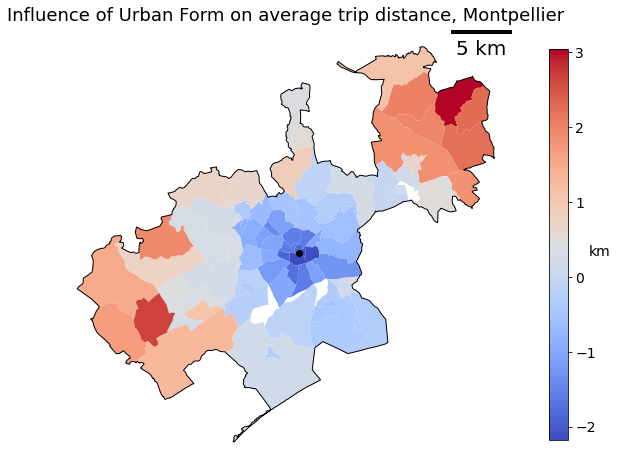

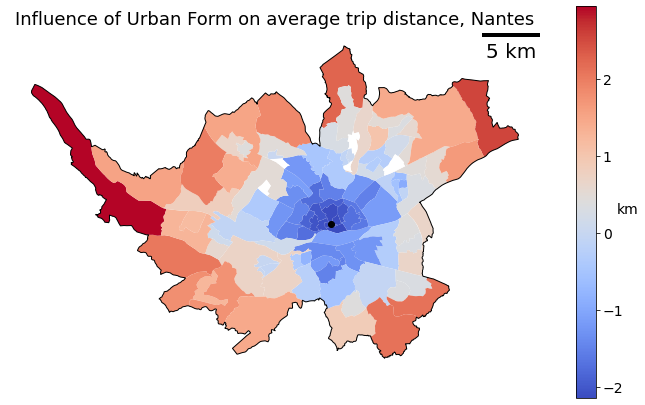

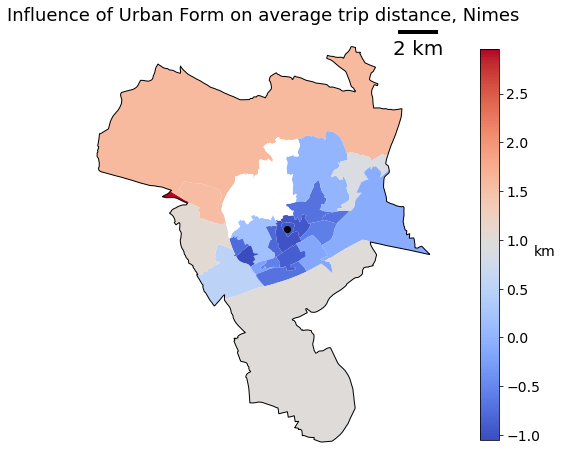

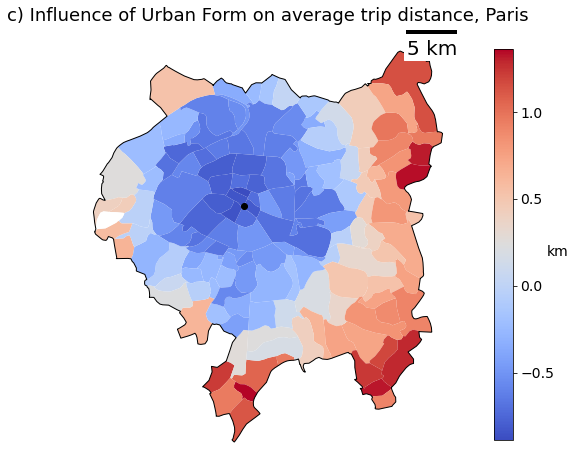

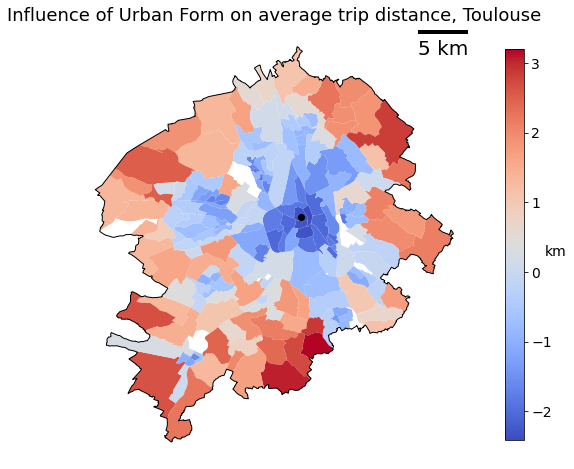

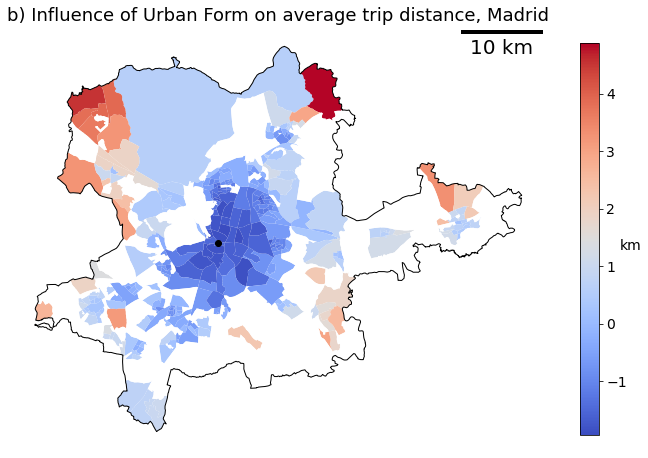

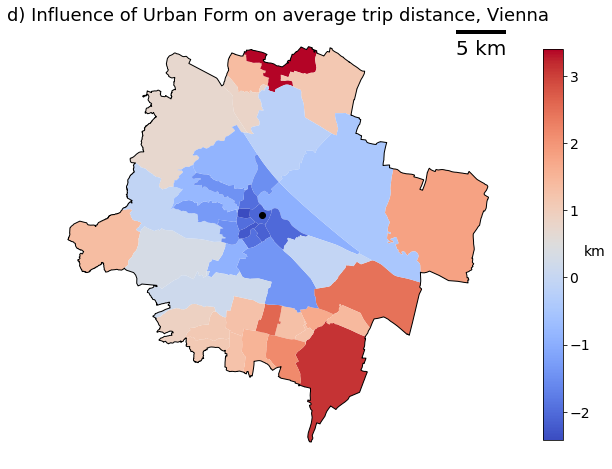

In [6]:
#city='Toulouse'
for city in cities_all:

    country=countries[cities_all.index(city)]
    print(city, country)
    if (country in ['Spain','France']) & (city not in ['Paris','Paris_large']):
        fp='../outputs/density_geounits/' + city + '_pop_density_mixres.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')
    elif city =='Paris':
        fp='../outputs/density_geounits/' + city + '_pop_density_lowres.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geo_unit')
        plz_gdf.rename(columns={'geo_unit':'geocode'},inplace=True)
    elif city =='Paris_large':
        fp='../outputs/density_geounits/Paris_pop_density_lowres_large.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geo_unit')
        plz_gdf.rename(columns={'geo_unit':'geocode'},inplace=True)
    else:
        fp='../outputs/density_geounits/' + city + '_pop_density.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')

    df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')

    fp='../outputs/ML_Results/shap/dist_agg/' + city + '.pkl'
    with open(fp, 'rb') as f:
        shap_values=pickle.load(f) 

    shap_values=shap_values*0.001

    fp='../outputs/ML_Results/shap/dist_agg/' + city + '_df.pkl'
    with open(fp, 'rb') as f:
        df_agg=pickle.load(f) 

    if (country == 'Germany'): 
        fp='../outputs/city_boundaries/' + city + '_basic.csv'
    else:
        fp='../outputs/city_boundaries/' + city + '.csv'
    boundary=import_csv_w_wkt_to_gdf(fp,crs=crs0)

    fp='../source/citycenters/centers.csv'
    centers=import_csv_w_wkt_to_gdf(fp,crs=4326)
    centers.to_crs(crs0, inplace=True)
    cp=centers.loc[centers['City']==city,]

    #feat_ori=shap_values.drop(columns={'Commute_Trip','IncomeDetailed_Numeric','Age'},errors='ignore')
    feat_ori=shap_values.loc[:,['DistCenter_res','DistSubcenter_res','UrbPopDensity_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','LU_UrbFab_res','LU_Comm_res']]
    feat_ori['All_UF']=feat_ori.sum(axis=1)

    df_plot_ori=df_agg[['Res_geocode']].reset_index(drop=True)
    df_plot_ori=df_agg[['Res_geocode']].drop_duplicates().reset_index(drop=True)
    df_plot_ori=df_plot_ori.merge(feat_ori,left_index=True,right_index=True)

    feat_plot=plz_gdf.loc[:,['geocode','geometry']].copy()
    feat_plot.rename(columns={'geocode':'Res_geocode'},inplace=True)

    df_plot_mean=df_plot_ori.groupby('Res_geocode').mean().reset_index()
    feat_plot=feat_plot.merge(df_plot_mean,how='left')

    fig, ax = plt.subplots(figsize=(12,8))
    #feat_plot.plot(column='All_UF',ax=ax,legend=True,cmap='coolwarm',missing_kwds= dict(color = "white"),vmin=-2000,vmax=4000)
    feat_plot.plot(column='All_UF',ax=ax,legend=True,cmap='coolwarm',missing_kwds= dict(color = "white"),legend_kwds={"label": "horizontal","shrink": 0.9})
    boundary.plot(edgecolor='k',facecolor='None',ax=ax)
    cp.plot(color='k',ax=ax)
    if city=='Berlin':
        title='a) Influence of Urban Form on average trip distance, '
    elif city == 'Madrid':
        title='b) Influence of Urban Form on average trip distance, '
    elif city == 'Paris':
        title='c) Influence of Urban Form on average trip distance, '
    elif city == 'Wien':
        title='d) Influence of Urban Form on average trip distance, Vienna'
    else:
        title='Influence of Urban Form on average trip distance, '

    if city=='Wien':
        ax.set_title(title,size=18)
        ax.add_artist(ScaleBar(1,font_properties={'size':20}))
    else:
        ax.set_title(title + city,size=18)
        ax.add_artist(ScaleBar(1,font_properties={'size':20}))
        

    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=14)
    cb_ax.set_ylabel('km',rotation=0,fontsize=14)
    plt.axis('off') # this removes the figure frame and the lat/lon coords
    plt.savefig('../outputs/ML_Results/result_figures/dist_agg/' + city + '_UF_map_ori.png',facecolor='w',dpi=300,bbox_inches='tight')

In [53]:
city='Madrid'
country=countries[cities_all.index(city)]
print(city, country)
if (country in ['Spain','France']) & (city not in ['Paris','Paris_large']):
    fp='../outputs/density_geounits/' + city + '_pop_density_mixres.csv'
    plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')
elif city =='Paris':
    fp='../outputs/density_geounits/' + city + '_pop_density_lowres.csv'
    plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geo_unit')
    plz_gdf.rename(columns={'geo_unit':'geocode'},inplace=True)
elif city =='Paris_large':
    fp='../outputs/density_geounits/Paris_pop_density_lowres_large.csv'
    plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geo_unit')
    plz_gdf.rename(columns={'geo_unit':'geocode'},inplace=True)
else:
    fp='../outputs/density_geounits/' + city + '_pop_density.csv'
    plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')

df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')

fp='../outputs/ML_Results/shap/dist_agg/' + city + '.pkl'
with open(fp, 'rb') as f:
    shap_values=pickle.load(f) 

shap_values=shap_values*0.001

fp='../outputs/ML_Results/shap/dist_agg/' + city + '_df.pkl'
with open(fp, 'rb') as f:
    df_agg=pickle.load(f) 

if (country == 'Germany'): 
    fp='../outputs/city_boundaries/' + city + '_basic.csv'
else:
    fp='../outputs/city_boundaries/' + city + '.csv'
boundary=import_csv_w_wkt_to_gdf(fp,crs=crs0)

fp='../source/citycenters/centers.csv'
centers=import_csv_w_wkt_to_gdf(fp,crs=4326)
centers.to_crs(crs0, inplace=True)
cp=centers.loc[centers['City']==city,]

feat_ori=shap_values.drop(columns={'Commute_Trip','IncomeDetailed_Numeric','Age','DistCenter_res'},errors='ignore')
# feat_ori['MaxImportance']=feat_ori.idxmax(axis=1)
feat_ori['MaxImportance']=feat_ori.apply(lambda s: s.abs().nlargest(1).index[0], axis=1)
#feat_ori['All_UF']=feat_ori.sum(axis=1)

df_plot_ori=df_agg[['Res_geocode']].reset_index(drop=True)
df_plot_ori=df_agg[['Res_geocode']].drop_duplicates().reset_index(drop=True)
df_plot_ori=df_plot_ori.merge(feat_ori,left_index=True,right_index=True)

feat_plot=plz_gdf.loc[:,['geocode','geometry']].copy()
feat_plot.rename(columns={'geocode':'Res_geocode'},inplace=True)
feat_plot=feat_plot.merge(df_plot_ori,how='left')

Madrid Spain


C:\Users\peter\AppData\Local\Temp\ipykernel_22216\1820869223.py:19: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')


<AxesSubplot:>

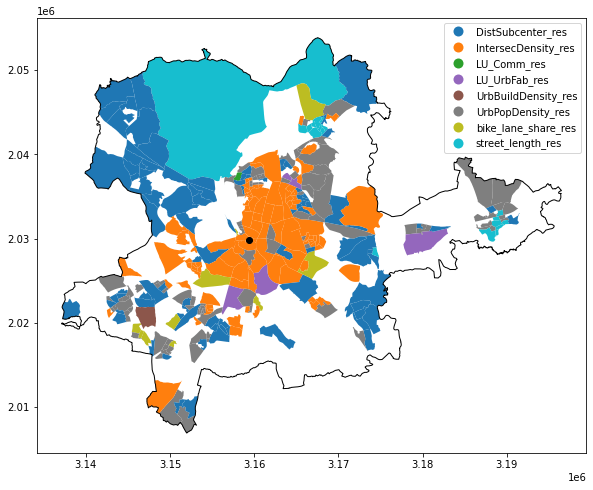

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
feat_plot.plot(column='MaxImportance',ax=ax,legend=True)
boundary.plot(edgecolor='k',facecolor='None',ax=ax)
cp.plot(color='k',ax=ax)